<a href="https://colab.research.google.com/github/dippatel1994/Project-X/blob/master/project_X_wikipedia_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.6 MB/s 


# Project description

Attached here is a dataset of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

You must create a model which predicts a probability of each type of toxicity for each comment.


### Import libraries

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score
from sklearn.multiclass import OneVsRestClassifier
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
import numpy as np

### Load dataset into dataframe

In [3]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
df = pd.read_excel('/content/drive/My Drive/project_x/toxic_comment_dataset.xlsx')

Mounted at /content/drive


### Analyse data

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# null value check
df.isnull().sum()

id                 0
comment_text     122
toxic              0
severe_toxic       0
obscene            0
threat             0
insult             0
identity_hate      0
dtype: int64

In [6]:
# find the percenatage of null value for comment_text
print("Total % of null value for comment_text: ", (df['comment_text'].isnull().sum()/ len(df))*100, "%" )

Total % of null value for comment_text:  0.0764549949552237 %


In [7]:
# remove null value since it is 0.07% only
df = df.dropna()
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159449.000000,159449.000000,159449.000000,159449.000000,159449.000000,159449.000000
mean,0.095755,0.009991,0.052882,0.002979,0.049326,0.008805
std,0.294256,0.099453,0.223799,0.054499,0.216549,0.093423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From describe() the low mean is indicating only few comments are actually classified

In [9]:
# Total count of un-classified comment data
count = len(df[(df['toxic']!=1) & (df['severe_toxic']!=1) & (df['obscene']!=1) & 
                            (df['threat']!=1) & (df['insult']!=1) & (df['identity_hate']!=1)])

print("Total count: ", count)
print("% of un-classified comments: ", (count/len(df))*100,"%" )

Total count:  143250
% of un-classified comments:  89.84063869952148 %


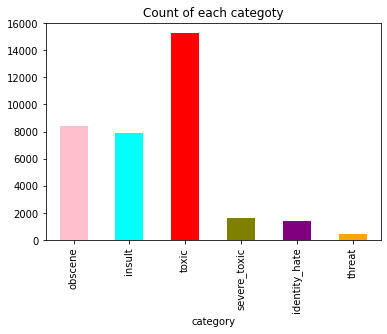

obscene           8432
insult            7865
toxic            15268
severe_toxic      1593
identity_hate     1404
threat             475
dtype: int64


In [10]:
# Count of each category
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

#Count of each category
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
count = []
color = ['pink','aqua','red','olive','purple','orange']
for i in cols_target:
  count.append((i,df[i].sum()))

data = pd.DataFrame(count, columns = ["category", "count"])

data.plot(x="category", y="count", kind="bar", color = color,legend=None)
plt.title("Count of each categoty")
plt.show()

print(df[cols_target].sum())

From above chart it is clear that data is higly imbalance 

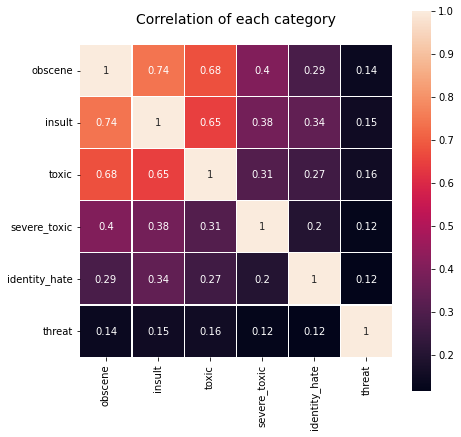

In [11]:
# Correlation of categories
plt.figure(figsize=(7,7))
plt.title('Correlation of each category',y=1.05,size=14)
sns.heatmap(df[cols_target].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,
           linecolor='white',annot=True)
plt.show()

It seems there are strong correlation between obscence, insult and toxic category

### Perform MLSMOTE operation to balance the data

In [12]:
# def get_tail_label(df):
#     """
#     Give tail label colums of the given target dataframe
    
#     args
#     df: pandas.DataFrame, target label df whose tail label has to identified
    
#     return
#     tail_label: list, a list containing column name of all the tail label
#     """
#     columns = df.columns
#     n = len(columns)
#     irpl = np.zeros(n)
#     for column in range(n):
#         irpl[column] = df[columns[column]].value_counts()[1]
#     irpl = max(irpl)/irpl
#     mir = np.average(irpl)
#     tail_label = []
#     for i in range(n):
#         if irpl[i] > mir:
#             tail_label.append(columns[i])
#     return tail_label

# def get_index(df):
#   """
#   give the index of all tail_label rows
#   args
#   df: pandas.DataFrame, target label df from which index for tail label has to identified
    
#   return
#   index: list, a list containing index number of all the tail label
#   """
#   tail_labels = get_tail_label(df)
#   index = set()
#   for tail_label in tail_labels:
#     sub_index = set(df[df[tail_label]==1].index)
#     index = index.union(sub_index)
#   return list(index)

# def get_minority_instace(X, y):
#     """
#     Give minority dataframe containing all the tail labels
    
#     args
#     X: pandas.DataFrame, the feature vector dataframe
#     y: pandas.DataFrame, the target vector dataframe
    
#     return
#     X_sub: pandas.DataFrame, the feature vector minority dataframe
#     y_sub: pandas.DataFrame, the target vector minority dataframe
#     """
#     index = get_index(y)
#     X_sub = X[X.index.isin(index)].reset_index(drop = True)
#     y_sub = y[y.index.isin(index)].reset_index(drop = True)
#     return X_sub, y_sub

# def nearest_neighbour(X):
#     """
#     Give index of 5 nearest neighbor of all the instance
    
#     args
#     X: np.array, array whose nearest neighbor has to find
    
#     return
#     indices: list of list, index of 5 NN of each element in X
#     """
#     nbs = NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
#     euclidean,indices= nbs.kneighbors(X)
#     return indices

# def MLSMOTE(X,y, n_sample):
#     """
#     Give the augmented data using MLSMOTE algorithm
    
#     args
#     X: pandas.DataFrame, input vector DataFrame
#     y: pandas.DataFrame, feature vector dataframe
#     n_sample: int, number of newly generated sample
    
#     return
#     new_X: pandas.DataFrame, augmented feature vector data
#     target: pandas.DataFrame, augmented target vector data
#     """
#     indices2 = nearest_neighbour(X)
#     n = len(indices2)
#     new_X = np.zeros((n_sample, X.shape[1]))
#     target = np.zeros((n_sample, y.shape[1]))
#     for i in range(n_sample):
#         reference = random.randint(0,n-1)
#         neighbour = random.choice(indices2[reference,1:])
#         all_point = indices2[reference]
#         nn_df = y[y.index.isin(all_point)]
#         ser = nn_df.sum(axis = 0, skipna = True)
#         target[i] = np.array([1 if val>2 else 0 for val in ser])
#         ratio = random.random()
#         gap = X.loc[reference,:] - X.loc[neighbour,:]
#         new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
#     new_X = pd.DataFrame(new_X, columns=X.columns)
#     target = pd.DataFrame(target, columns=y.columns)
#     new_X = pd.concat([X, new_X], axis=0)
#     target = pd.concat([y, target], axis=0)
#     return new_X, target

# X = df.comment_text
# y = df.drop(['id', 'comment_text'], axis = 1)
# # X, y = create_dataset()
# X_sub, y_sub = get_minority_instace(X, y)
# X_res,y_res =MLSMOTE(X_sub, y_sub, 100)


In [13]:
# # DO NOT RUN THIS CELL. IT TAKES 15 MINS
# import spacy
# import en_core_web_sm
# nlp = en_core_web_sm.load()
# nonstop_tokens = []
# for doc in nlp.pipe(df['comment_text'].astype('unicode').values, batch_size=50):
#   if doc.has_annotation("DEP"):
#     nonstop_tokens.append([t.lower_ for t in doc if t.is_alpha and not t.is_stop])
#   else:
#     nonstop_tokens.append(None)
# df['nonstop_tokens'] = nonstop_tokens



In [14]:
# # Most frequent words for each category
# for label in cols_target:
#     word_list = list(df.loc[df[label]==1, 'nonstop_tokens'].explode())
#     most_common = collections.Counter(word_list).most_common(20)
#     words = [w for w,_ in most_common]
#     counts = [c for _,c in most_common]
#     plt.figure(figsize=(20, 10))
#     ax = sns.barplot(x=words, y=counts, palette=['r', 'g'])
#     # ax.color_palette("rocket", as_cmap=True)
#     ax.set_title(f'Label = {label}', fontsize=15)
#     ax.tick_params(labelsize=15)
#     ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

### Data Cleaning operations

In [15]:
# Remove stope words from comment_text
df['comment_text'] = df['comment_text'].str.lower()
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS]
                   )
df['comment_text'] = df['comment_text'].apply(lambda text: cleaning_stopwords(text))
df['comment_text'].head()

0    explanation edits made username hardcore metal...
1    d'aww! matches background colour i'm seemingly...
2    hey man, i'm really not trying edit war. it's ...
3    " can't make real suggestions improvement - wo...
4      you, sir, hero. chance remember page that's on?
Name: comment_text, dtype: object

In [16]:
# Remove special characters from comment_text
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['comment_text'] = df['comment_text'].apply(lambda x: cleaning_punctuations(x))
df['comment_text'].head()

0    explanation edits made username hardcore metal...
1    daww matches background colour im seemingly st...
2    hey man im really not trying edit war its guy ...
3     cant make real suggestions improvement  wonde...
4           you sir hero chance remember page thats on
Name: comment_text, dtype: object

In [17]:
# Remove repeating characters from comment_text
import re
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['comment_text'] = df['comment_text'].apply(lambda x: cleaning_repeating_char(x))
df['comment_text'].tail()

159566    and second time asking view completely contrad...
159567          ashamed horrible thing put talk page1281993
159568    spitzer umm theres no actual article prostitut...
159569    looks like actually put speedy first version d...
159570      really dont think understand came idea bad r...
Name: comment_text, dtype: object

In [18]:
# Remove URLs from comment_text
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['comment_text'] =df['comment_text'].apply(lambda x: cleaning_URLs(x))
df['comment_text'].tail()

159566    and second time asking view completely contrad...
159567          ashamed horrible thing put talk page1281993
159568    spitzer umm theres no actual article prostitut...
159569    looks like actually put speedy first version d...
159570      really dont think understand came idea bad r...
Name: comment_text, dtype: object

In [19]:
# Remove numbers from comment_text
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['comment_text'] = df['comment_text'].apply(lambda x: cleaning_numbers(x))
df['comment_text'].tail()

159566    and second time asking view completely contrad...
159567                 ashamed horrible thing put talk page
159568    spitzer umm theres no actual article prostitut...
159569    looks like actually put speedy first version d...
159570      really dont think understand came idea bad r...
Name: comment_text, dtype: object

In [20]:
# from nltk.tokenize import RegexpTokenizer
# tokenizer = RegexpTokenizer(r'\w+')
# df['comment_text']= df['comment_text'].apply(tokenizer.tokenize)
# df['comment_text'].head()


In [21]:
# from sklearn.feature_extraction.text import CountVectorizer
# m1 = CountVectorizer()
# x = m1.fit_transform(df["comment_text"])

### Split into train/test sets

In [22]:
from sklearn.model_selection import train_test_split
X = df.comment_text
y = df.drop(['id', 'comment_text'], axis = 1)

X_train,X_test, y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=1) #stratify=y

### Prepare TF-IDF vectors

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',     
    analyzer='word',            
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 3),         
    stop_words='english',
    sublinear_tf=True)

word_vectorizer.fit(X_train)    
train_word_features = word_vectorizer.transform(X_train)

In [24]:
word_vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': 'unicode',
 'sublinear_tf': True,
 'token_pattern': '\\w{1,}',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [25]:
X_train_transformed = word_vectorizer.transform(X_train)
x_test_transformed = word_vectorizer.transform(X_test)
# print(x_test_transformed)

## Approach 1: Adapted Algorithm

In [26]:
# Logistic regression based on TF-IDF

lr_classifier = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=45)

classifier = OneVsRestClassifier(lr_classifier)
classifier.fit(X_train_transformed, y_train)

y_train_pred_proba = classifier.predict_proba(X_train_transformed)
y_test_pred_proba = classifier.predict_proba(x_test_transformed)


### Model evaluation 

In [27]:
# roc_auc_score_train = roc_auc_score(y_train, y_train_pred_proba,average='weighted')
roc_auc_score_test = roc_auc_score(y_test, y_test_pred_proba,average='weighted')

# print("ROC AUC Score Train:", roc_auc_score_train)
print("ROC AUC Score weighted score:", roc_auc_score_test)

roc_auc_score_test = roc_auc_score(y_test, y_test_pred_proba,average='weighted')
print("ROC AUC Score for all class:", roc_auc_score_test)

ROC AUC Score weighted score: 0.9789050986953947
ROC AUC Score for all class: 0.9789050986953947


# Approach 2: Label Power set

- It assigns unique label for each combinations of output labels
- Trade-off: Number of training data increases -> Number of classes/labels will increase

In [ ]:
# from skmultilearn.problem_transform import LabelPowerset
# from sklearn.naive_bayes import GaussianNB

# # initialize Label Powerset multi-label classifier
# # with a gaussian naive bayes base classifier
# classifier = LabelPowerset(GaussianNB())

# # train
# classifier.fit(X_train_transformed, y_train)

# # predict
# predictions = classifier.predict(x_test_transformed)

# accuracy_score(y_test,predictions)

## Approach 3 : Binary Relevance
- Treat each label as seperate classification problem

In [1]:
logreg = LogisticRegression(C=12.0)

for label in cols_target:
    print('... Processing {}'.format(label))
    y = y_train[label]
    y_te = y_test[label]
    logreg = logreg.fit(X_train_transformed, y)
    y_pred_X = logreg.predict(X_train_transformed)
    y_pred_test = logreg.predict(x_test_transformed)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    print(classification_report(y, y_pred_X))
    print('Testing accuracy is {}'.format(accuracy_score(y_te, y_pred_test)))
    print(classification_report(y_te, y_pred_test))
    test_y_prob = logreg.predict_proba(X_train_transformed)[:,1] # compute the predicted probabilities for X_test_transformed

NameError: ignored